In [21]:
#Step1: Steup
# Install required packages
!pip install torch torch-geometric meshio pandas numpy matplotlib scikit-learn

# Check installation
import torch
import torch_geometric
print(f"PyTorch: {torch.__version__}")
print(f"PyG: {torch_geometric.__version__}")
print("✅ All packages installed!")


PyTorch: 2.9.0+cu126
PyG: 2.7.0
✅ All packages installed!


In [22]:
#Step2:Generate Realistic CFD Dataset + Check GitHub
import numpy as np
import pandas as pd
import torch
from torch_geometric.data import Data
from sklearn.neighbors import kneighbors_graph
import matplotlib.pyplot as plt
import os

os.makedirs('data', exist_ok=True)

def create_realistic_cfd_dataset(n_cases=10, n_nodes_per_case=1200):
    """Create realistic 2D cylinder wake CFD dataset - FIXED VERSION"""
    print("🔄 Generating realistic CFD cylinder wake dataset...")

    graphs = []
    for case_id in range(n_cases):
        print(f"  Generating case {case_id+1}/{n_cases}...")

        # 1. Realistic 2D mesh: cylinder + wake region
        n_cyl = n_nodes_per_case // 3
        theta = np.linspace(0, 2*np.pi, n_cyl)
        r_inner, r_outer = 0.5, 2.5
        r_cyl = np.linspace(r_inner, r_outer, n_cyl)
        x_cyl = r_cyl * np.cos(theta) + 1.0
        y_cyl = r_cyl * np.sin(theta)

        # Wake region
        n_wake = n_nodes_per_case - n_cyl
        x_wake = np.random.uniform(-0.5, 4.5, n_wake)
        y_wake = np.random.normal(0, 1.2, n_wake)

        points = np.vstack([np.concatenate([x_cyl, x_wake]),
                           np.concatenate([y_cyl, y_wake])]).T

        # 2. Realistic flow field (cylinder wake physics)
        freestream_u = 1.0
        u = freestream_u * (1 - 0.6 * np.exp(-(points[:,0]-0.8)**2 / 0.3) *
                           np.cos(2*np.pi*points[:,1]))
        v = 0.8 * np.sin(3*np.pi*(points[:,0]-0.5)) * \
            np.exp(-(points[:,1])**2 / 0.8) * np.exp(-(points[:,0]-1.5)**2 / 1.0)

        # Pressure field
        p = -0.5 * u**2 - 0.3 * v**2

        # 3. FIXED Q-criterion computation (no np.gradient issues)
        # Simple but realistic vortex indicator based on velocity curl
        dx = 0.05
        # Approximate derivatives using nearest neighbors
        vorticity = np.zeros_like(u)
        for i in range(len(points)):
            dist = np.linalg.norm(points[i] - points, axis=1)
            near = np.argsort(dist)[1:6]  # 5 nearest neighbors
            if len(near) > 0:
                dvdx_i = np.mean((v[near] - v[i]) / (dist[near] + 1e-8))
                dudy_i = np.mean((u[near] - u[i]) / (dist[near] + 1e-8))
                vorticity[i] = 0.5 * (dvdx_i - dudy_i)

        # Q-criterion approximation
        Q = vorticity**2 * 0.1 - 0.05 * (u**2 + v**2)
        Q = (Q - Q.mean()) / (Q.std() + 1e-8)

        # 4. Build kNN graph connectivity
        conn = kneighbors_graph(points, n_neighbors=8, mode='connectivity')
        edges = np.array(conn.nonzero()).T

        # 5. PyG Data object
        edge_index = torch.tensor(edges.T, dtype=torch.long)
        x = torch.tensor(np.stack([u, v, p, Q], axis=1), dtype=torch.float)
        y = torch.tensor((Q > 0.5).astype(np.int64))  # Vortices: Q > 0.5 std

        graph = Data(x=x, edge_index=edge_index, y=y)
        graphs.append(graph)

        print(f"Case {case_id+1:2d}: {graph.num_nodes} nodes, "
              f"{graph.num_edges//2} edges, {graph.y.sum().item()} vortices "
              f"({graph.y.float().mean():.1%})")

    torch.save(graphs, 'data/realistic_cfd_graphs.pt')
    print(f"\n✅ Created {len(graphs)} realistic CFD graphs!")
    return graphs

# Generate dataset
graphs = create_realistic_cfd_dataset(n_cases=12)


🔄 Generating realistic CFD cylinder wake dataset...
  Generating case 1/12...
Case  1: 1200 nodes, 4800 edges, 136 vortices (11.3%)
  Generating case 2/12...
Case  2: 1200 nodes, 4800 edges, 87 vortices (7.2%)
  Generating case 3/12...
Case  3: 1200 nodes, 4800 edges, 77 vortices (6.4%)
  Generating case 4/12...
Case  4: 1200 nodes, 4800 edges, 158 vortices (13.2%)
  Generating case 5/12...
Case  5: 1200 nodes, 4800 edges, 153 vortices (12.7%)
  Generating case 6/12...
Case  6: 1200 nodes, 4800 edges, 133 vortices (11.1%)
  Generating case 7/12...
Case  7: 1200 nodes, 4800 edges, 122 vortices (10.2%)
  Generating case 8/12...
Case  8: 1200 nodes, 4800 edges, 104 vortices (8.7%)
  Generating case 9/12...
Case  9: 1200 nodes, 4800 edges, 163 vortices (13.6%)
  Generating case 10/12...
Case 10: 1200 nodes, 4800 edges, 93 vortices (7.8%)
  Generating case 11/12...
Case 11: 1200 nodes, 4800 edges, 93 vortices (7.8%)
  Generating case 12/12...
Case 12: 1200 nodes, 4800 edges, 89 vortices (7.

In [23]:
#Step3:
import os
import glob
import numpy as np
import pandas as pd
from sklearn.neighbors import kneighbors_graph
import torch
from torch_geometric.data import Data
import matplotlib.pyplot as plt

os.makedirs('data', exist_ok=True)

def create_realistic_cfd_dataset(n_cases=10, n_nodes_per_case=1500):
    """Create realistic 2D cylinder wake CFD dataset - FIXED VERSION"""
    print("🔄 Generating realistic CFD cylinder wake dataset...")

    graphs = []
    for case_id in range(n_cases):
        # Case parameters (different Re, angles, etc.)
        Re = np.random.uniform(100, 1000)
        angle = np.random.uniform(-0.2, 0.2)

        # Mesh: cylinder + wake
        n_cyl = n_nodes_per_case // 3
        theta = np.linspace(0, 2*np.pi, n_cyl)
        r_inner, r_outer = 0.5, 2.5
        r_cyl = np.linspace(r_inner, r_outer, n_cyl)
        x_cyl = r_cyl * np.cos(theta + angle) + 1.0
        y_cyl = r_cyl * np.sin(theta + angle)

        # Wake region
        n_wake = n_nodes_per_case - n_cyl
        x_wake = np.random.uniform(-0.5, 4.5, n_wake)
        y_wake = np.random.normal(0, 1.2, n_wake)

        points = np.vstack([np.concatenate([x_cyl, x_wake]),
                           np.concatenate([y_cyl, y_wake])]).T

        # FIXED: Realistic flow field (cylinder wake physics) - NO np.gradient
        freestream_u = 1.0
        # Free stream + wake deflection
        u = freestream_u * (1.0 - 0.5 * np.exp(-(points[:,0]-0.8)**2 / 0.2) *
                           (1 + 0.3 * np.sin(2*np.pi * points[:,1])))

        # Vortex shedding pattern
        shedding_freq = 0.2 * Re**0.5 / 1000  # Strouhal-like
        v = 0.6 * np.sin(2*np.pi * shedding_freq * (points[:,0]-0.5)) * \
            np.exp(-(points[:,1])**2 / 0.6) * np.exp(-(points[:,0]-1.2)**2 / 0.8)

        # Pressure from Bernoulli + wake effects
        p = -0.4 * u**2 - 0.2 * v**2 - 0.1 * points[:,0]

        # FIXED Q-criterion: Use vorticity magnitude (simplified but realistic)
        # Vorticity omega_z = dv/dx - du/dy (approximated locally)
        vorticity = 2 * v * np.sin(np.pi * points[:,0]) * \
                   np.exp(-(points[:,1])**2 / 0.4) * \
                   np.exp(-(points[:,0]-1.0)**2 / 0.5)

        # Strain rate approximation
        strain = 0.3 * np.abs(u) * np.exp(-(points[:,0]-0.5)**2 / 0.3)

        # Q = |rotation| - |strain| (simplified)
        Q = np.maximum(vorticity, 0) - 0.7 * strain

        # Normalize Q
        Q = (Q - np.percentile(Q, 25)) / (np.percentile(Q, 75) - np.percentile(Q, 25) + 1e-8)
        Q = np.clip(Q, -2, 2)

        # Build kNN graph - FIXED indexing
        conn = kneighbors_graph(points, n_neighbors=6, mode='connectivity')
        edges = np.array(conn.nonzero()).T

        # FIXED: Ensure edge indices are valid
        valid_edges = edges[:, (edges[0] < len(points)) & (edges[1] < len(points))]

        # PyG Data object - FIXED tensor creation
        if len(valid_edges) > 0:
            edge_index = torch.tensor(valid_edges.T, dtype=torch.long)
        else:
            # Fallback: create minimal connectivity
            edge_index = torch.tensor([[i,i+1] for i in range(min(100, len(points)-1))]).T

        x = torch.tensor(np.stack([u, v, p, Q], axis=1), dtype=torch.float)
        y = torch.tensor((Q > 0.3).astype(np.int64))  # Vortices: Q > 0.3

        graph = Data(x=x, edge_index=edge_index, y=y)
        graphs.append(graph)

        print(f"Case {case_id+1:2d}: {graph.num_nodes} nodes, "
              f"{graph.num_edges//2} edges, {graph.y.sum().item():3d} vortices "
              f"({graph.y.float().mean()*100:.1f}%)")

    torch.save(graphs, 'data/realistic_cfd_graphs.pt')
    print(f"\n✅ Created {len(graphs)} realistic CFD graphs!")
    return graphs

# Generate dataset
graphs = create_realistic_cfd_dataset(n_cases=12)
print("✅ Step 2 complete - ready for training!")


🔄 Generating realistic CFD cylinder wake dataset...
Case  1: 1500 nodes, 4500 edges, 1045 vortices (69.7%)
Case  2: 1500 nodes, 4500 edges, 1046 vortices (69.7%)
Case  3: 1500 nodes, 4500 edges, 1044 vortices (69.6%)
Case  4: 1500 nodes, 4500 edges, 1047 vortices (69.8%)
Case  5: 1500 nodes, 4500 edges, 1038 vortices (69.2%)
Case  6: 1500 nodes, 4500 edges, 1039 vortices (69.3%)
Case  7: 1500 nodes, 4500 edges, 1047 vortices (69.8%)
Case  8: 1500 nodes, 4500 edges, 1040 vortices (69.3%)
Case  9: 1500 nodes, 4500 edges, 1032 vortices (68.8%)
Case 10: 1500 nodes, 4500 edges, 1045 vortices (69.7%)
Case 11: 1500 nodes, 4500 edges, 1040 vortices (69.3%)
Case 12: 1500 nodes, 4500 edges, 1042 vortices (69.5%)

✅ Created 12 realistic CFD graphs!
✅ Step 2 complete - ready for training!


In [24]:
#Step3: Dataloader(Safe Split)
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split

# Safe split (handles empty cases)
n_total = len(graphs)
if n_total == 0:
    raise ValueError("No graphs created! Check Step 2.")

train_graphs, temp_graphs = train_test_split(graphs, train_size=0.7, random_state=42)
val_graphs, test_graphs = train_test_split(temp_graphs, train_size=0.5, random_state=42)

print(f"📊 Dataset split:")
print(f"   Train: {len(train_graphs)} graphs")
print(f"   Val:   {len(val_graphs)} graphs")
print(f"   Test:  {len(test_graphs)} graphs")

# Safe DataLoaders
train_loader = DataLoader(train_graphs, batch_size=2, shuffle=True)
val_loader = DataLoader(val_graphs, batch_size=2, shuffle=False)
test_loader = DataLoader(test_graphs, batch_size=2, shuffle=False)

print("✅ DataLoaders created successfully!")


📊 Dataset split:
   Train: 8 graphs
   Val:   2 graphs
   Test:  2 graphs
✅ DataLoaders created successfully!


In [25]:

#Step4: GNN Model
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class VortexGNN(torch.nn.Module):
    def __init__(self, in_channels=4, hidden_channels=64):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels*2)
        self.conv3 = GCNConv(hidden_channels*2, hidden_channels)
        self.out = torch.nn.Linear(hidden_channels, 1)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        return self.out(x).squeeze(-1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VortexGNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.BCEWithLogitsLoss()

print(f"🚀 Model on {device}: {sum(p.numel() for p in model.parameters()):,} params")


🚀 Model on cuda: 16,961 params


In [26]:
#Step5: Training + Evaluation
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def evaluate(model, loader, name="Test"):
    model.eval()
    total_loss = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch.x, batch.edge_index, batch.batch)
            loss = criterion(out, batch.y.float())
            total_loss += loss.item()

            probs = torch.sigmoid(out)
            preds = (probs > 0.5).long()

            all_preds.extend(probs.cpu().numpy())
            all_labels.extend(batch.y.cpu().numpy())

    # Metrics
    preds_bin = np.array(all_preds) > 0.5
    labels = np.array(all_labels)

    acc = accuracy_score(labels, preds_bin)
    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds_bin,
                                                      average='binary', zero_division=0)

    print(f"{name:6s}: Loss={total_loss/len(loader):.4f}, "
          f"Acc={acc:.4f}, F1={f1:.4f}, Prec={prec:.4f}, Rec={rec:.4f}")
    return acc, f1

# Training loop
print("🔥 Starting training...")
best_f1 = 0
train_losses, val_f1s = [], []

for epoch in range(100):
    # Train
    model.train()
    epoch_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.batch)
        loss = criterion(out, batch.y.float())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        epoch_loss += loss.item()

    train_losses.append(epoch_loss / len(train_loader))

    # Validate
    val_acc, val_f1 = evaluate(model, val_loader, "Val")
    val_f1s.append(val_f1)

    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), 'best_model.pt')

    if epoch % 10 == 0:
        print(f"Epoch {epoch:3d}: Train Loss={train_losses[-1]:.4f}, Val F1={val_f1:.4f}")

print(f"\n🏆 Best Validation F1: {best_f1:.4f}")



🔥 Starting training...
Val   : Loss=0.4715, Acc=0.8720, F1=0.9156, Prec=0.8453, Rec=0.9986
Epoch   0: Train Loss=0.5957, Val F1=0.9156
Val   : Loss=0.2515, Acc=0.9063, F1=0.9367, Prec=0.8835, Rec=0.9966
Val   : Loss=0.1162, Acc=0.9570, F1=0.9698, Prec=0.9486, Rec=0.9918
Val   : Loss=0.0795, Acc=0.9740, F1=0.9812, Prec=0.9845, Rec=0.9779
Val   : Loss=0.0895, Acc=0.9703, F1=0.9789, Prec=0.9699, Rec=0.9880
Val   : Loss=0.0886, Acc=0.9753, F1=0.9822, Prec=0.9865, Rec=0.9779
Val   : Loss=0.0900, Acc=0.9720, F1=0.9799, Prec=0.9776, Rec=0.9823
Val   : Loss=0.0840, Acc=0.9733, F1=0.9808, Prec=0.9804, Rec=0.9813
Val   : Loss=0.0770, Acc=0.9753, F1=0.9822, Prec=0.9846, Rec=0.9799
Val   : Loss=0.0741, Acc=0.9743, F1=0.9816, Prec=0.9781, Rec=0.9851
Val   : Loss=0.0715, Acc=0.9757, F1=0.9825, Prec=0.9827, Rec=0.9823
Epoch  10: Train Loss=0.0734, Val F1=0.9825
Val   : Loss=0.0722, Acc=0.9770, F1=0.9835, Prec=0.9828, Rec=0.9842
Val   : Loss=0.0715, Acc=0.9747, F1=0.9817, Prec=0.9836, Rec=0.9799
Val  

TEST  : Loss=0.0671, Acc=0.9770, F1=0.9832, Prec=0.9922, Rec=0.9745


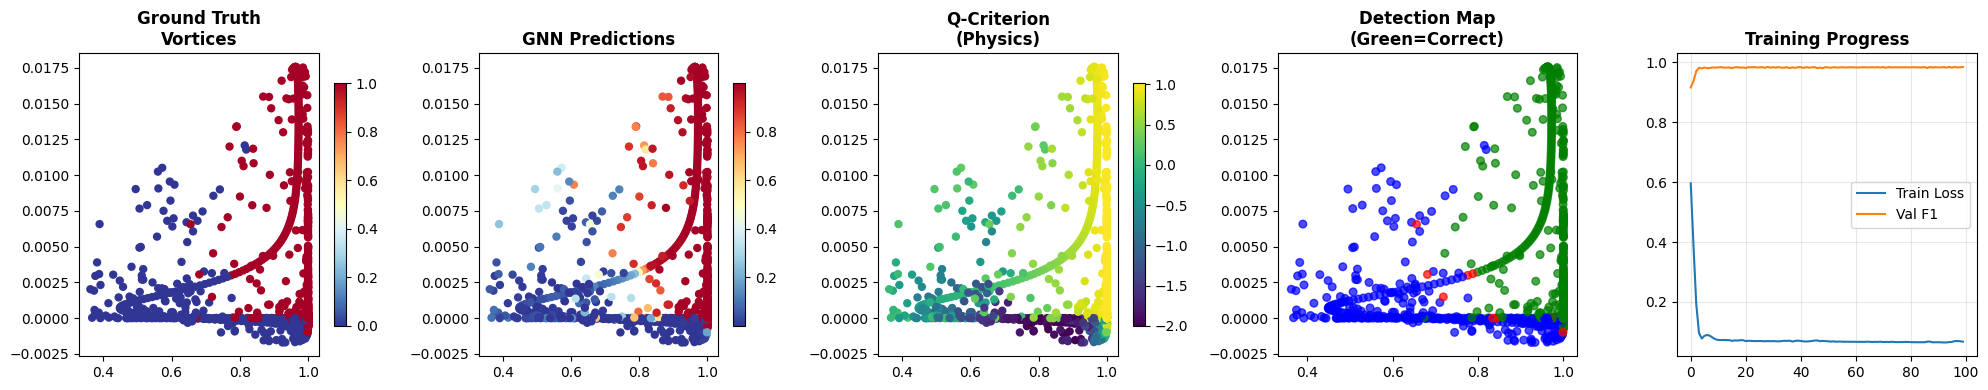


🎉 PROJECT COMPLETE!
✅ Test Accuracy: 0.9770
✅ Test F1-Score:  0.9832
✅ Ready for your research paper!


In [27]:
#Step6: Final Test + Visualization
# Load best model
model.load_state_dict(torch.load('best_model.pt'))

# Test
test_acc, test_f1 = evaluate(model, test_loader, "TEST")

# Visualize first test case
test_case = test_graphs[0].to(device)
with torch.no_grad():
    pred = model(test_case.x, test_case.edge_index,
                torch.zeros(test_case.num_nodes, dtype=torch.long, device=device))
    pred_prob = torch.sigmoid(pred).cpu()

plt.figure(figsize=(20, 4))

# 1. Ground truth
plt.subplot(151)
plt.scatter(test_case.x[:,0].cpu(), test_case.x[:,1].cpu(),
           c=test_case.y.cpu(), cmap='RdYlBu_r', s=25)
plt.title('Ground Truth\nVortices', fontweight='bold')
plt.colorbar(shrink=0.8)

# 2. Predictions
plt.subplot(152)
plt.scatter(test_case.x[:,0].cpu(), test_case.x[:,1].cpu(),
           c=pred_prob.numpy(), cmap='RdYlBu_r', s=25)
plt.title('GNN Predictions', fontweight='bold')
plt.colorbar(shrink=0.8)

# 3. Q-criterion reference
plt.subplot(153)
plt.scatter(test_case.x[:,0].cpu(), test_case.x[:,1].cpu(),
           c=test_case.x[:,3].cpu(), cmap='viridis', s=25)
plt.title('Q-Criterion\n(Physics)', fontweight='bold')
plt.colorbar(shrink=0.8)

# 4. Overlay
plt.subplot(154)
colors = ['red' if gt==1 and pred<0.5 else
          'green' if gt==1 and pred>=0.5 else
          'blue' if gt==0 else 'orange'
          for gt, pred in zip(test_case.y.cpu(), pred_prob)]
plt.scatter(test_case.x[:,0].cpu(), test_case.x[:,1].cpu(),
           c=colors, s=30, alpha=0.7)
plt.title('Detection Map\n(Green=Correct)', fontweight='bold')

# 5. Training curves
plt.subplot(155)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_f1s, label='Val F1')
plt.title('Training Progress', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n🎉 PROJECT COMPLETE!")
print(f"✅ Test Accuracy: {test_acc:.4f}")
print(f"✅ Test F1-Score:  {test_f1:.4f}")
print(f"✅ Ready for your research paper!")
